In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import feather


from sklearn.preprocessing import StandardScaler, PolynomialFeatures   
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

# Charge le fichier feather
df = pd.read_feather('data/energy_clean.ftr')
df = df.set_index('date_heure')

prod = df[['annee', 'mois', 'jour', 'consommation', 'total_prod']]
# Conversion en Gigawatt
prod['total_prod'] = prod['total_prod'].apply(lambda x: round(x/1000, 5))
prod['consommation'] = prod['consommation'].apply(lambda x: round(x/1000, 5))


data = prod.groupby(['annee','mois', 'jour'])[['total_prod']].sum().reset_index()

data.to_feather('data/lr_prod.ftr')


# I - Régression Linéaire: Production

Nous allons tester ici une régression linéaire simple avec pour `features` *annee*, *mois*, *jour* sur la `target` *total_prod*.

## I.1 - Interprétation des résultats

Le score R2 sur le jeu d'entrainement est très faible tout comme la validation croisée.

Effectivement, en affichant la distribution de la production dans le temps, nous voyons bien une forme de ***saisonnalité***.

Cependant, nous constatons que les variables `total_prod` et `consommation` sont bien corrélées entre elles comme le montre nuage de points ainsi que le heatmap.

## I.2 - Conclusions

Il n'est pas possible d'intégrer la variable `consommation` aussi facilement au risque d'avoir un biai important: la variable consommation doit être prédite au préalable.

In [2]:
# Target et Features
target = data.total_prod.astype(int)
features = data.drop(columns=['total_prod'])
# Découpe en jeu d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2)
# instancie un modèle de régression linéaire simple
lr = LinearRegression()
# Entraine le modèle
lr.fit(X_train, y_train)

print('R2: ', lr.score(X_train, y_train))
print('CV: ', cross_val_score(lr, X_train, y_train).mean())

R2:  0.1282605652642289
CV:  0.1262949009323368


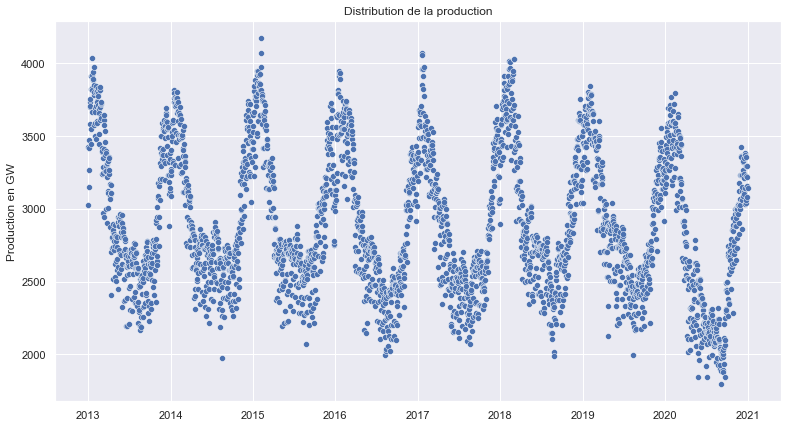

In [3]:
# Avec un timeserie en index, on peut grouper facilement avec pd.Grouper
# ici, je groupe par jours
data = prod.groupby(pd.Grouper(freq='D'))[['consommation','total_prod']].sum().reset_index()
data.index = pd.to_datetime(data['date_heure'])

# Affiche un nuage de points sur la production
plt.figure(figsize=(13, 7))
sns.set_theme()
ax = sns.scatterplot(data=data, x='date_heure', y='total_prod')
ax.set_title('Distribution de la production')
ax.set_ylabel('Production en GW')
ax.set_xlabel(None)
plt.savefig("Outputs/02_-_Distrib_prod.png", dpi=150, bbox_inches='tight')

plt.show()

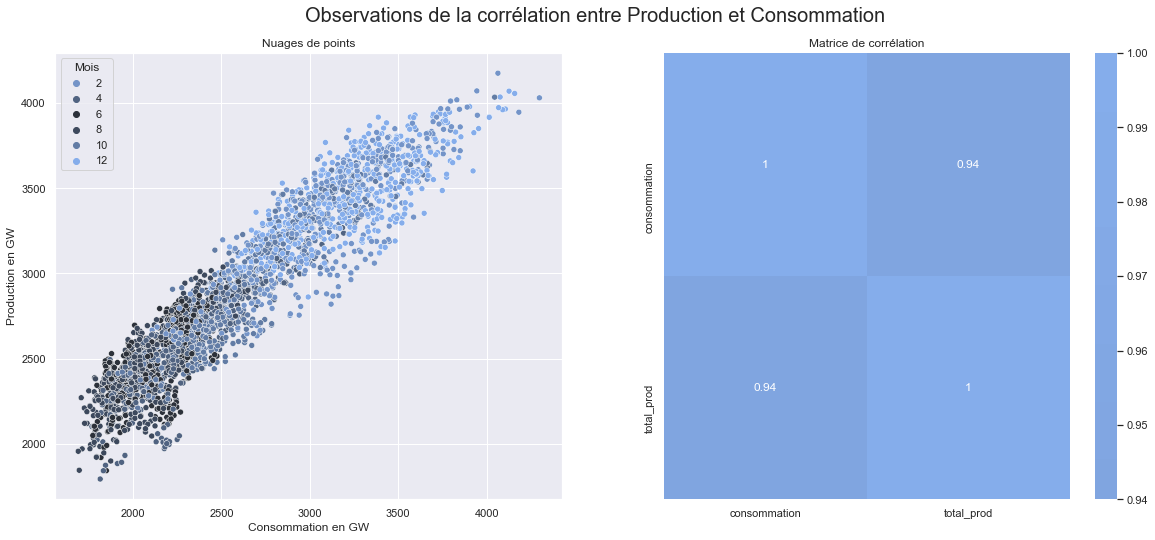

In [4]:
# Créer une palette de couleurs divergentes similaires sur les extrèmes pour souligner la saisonnalité (Janvier est presque comme Décembre)
palette = sns.diverging_palette(250, 250, l=70, center="dark", as_cmap=True)
# 2 graphiques en ligne
fig, ax = plt.subplots(1,2, figsize=(20, 8))

fig.suptitle('Observations de la corrélation entre Production et Consommation', fontsize=20)
fig.subplots_adjust(top=.9)

scatter = sns.scatterplot(data=data, x='consommation', y='total_prod', hue=data.index.month, palette=palette, ax=ax[0])
scatter.legend(title="Mois")
scatter.set_xlabel('Consommation en GW')
scatter.set_ylabel('Production en GW')
scatter.set_title('Nuages de points')

heatmap = sns.heatmap(data.corr().apply(lambda x: round(x, 2)), center=0, annot=True, cmap=palette, ax=ax[1])
heatmap.set_title('Matrice de corrélation')

plt.savefig("Outputs/02_-_Correlation_prod_conso_mois.png", dpi=150, bbox_inches='tight')

plt.show()

# II - Régression Linéaire: Consommation

Nous allons tester ici une régression linéaire simple avec pour `features` *annee*, *mois*, *jour* sur la `target` *consommation*.

## II.1 - Interprétation des résultats

Le score R2 sur le jeu d'entrainement est très faible tout comme la validation croisée.

Effectivement, en affichant la distribution de la consommation dans le temps, nous voyons bien une forme de ***saisonnalité***.

## II.2 - Conclusions

La régression linéaire telle qu'elle n'est pas intéressante. Je ne pourrait donc pas intégrer la variable *consommation* dans le modèle de régression linéaire simple.

Je vais tester un modèle polynomial pour la suite.

In [2]:
data = prod.groupby(['annee','mois', 'jour'])[['consommation']].sum().reset_index()
data.to_feather('data/lr_conso.ftr')


In [6]:
target = data.consommation.astype(int)
features = data.drop(columns=['consommation'])

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.2)

lr = LinearRegression()
lr.fit(X_train, y_train)

print('R2 Train: ', lr.score(X_train, y_train))
print('CV Train: ', cross_val_score(lr, X_train, y_train).mean())

y_pred = lr.predict(X_test)


R2 Train:  0.06473269154884331
CV Train:  0.061887716660407


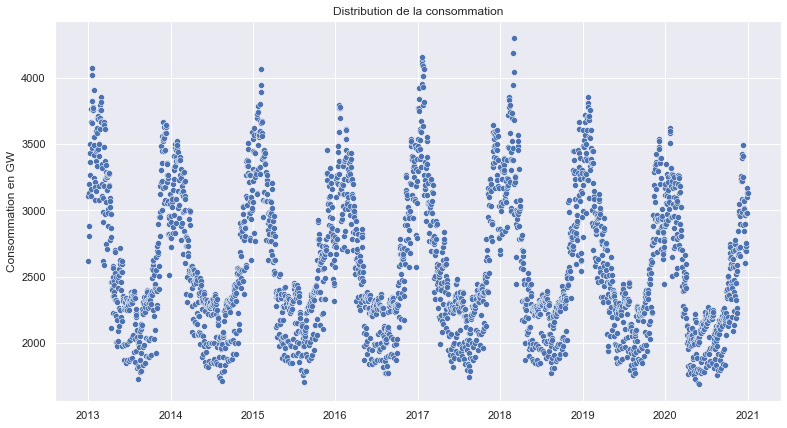

In [7]:
# Avec un timeserie en index, on peut grouper facilement avec pd.Grouper
# ici, je groupe par jours
data = prod.groupby(pd.Grouper(freq='D'))[['consommation','total_prod']].sum().reset_index()
data.index = pd.to_datetime(data['date_heure'])

# Affiche un nuage de points sur la production
plt.figure(figsize=(13, 7))
sns.set_theme()
sns.scatterplot(data=data, x='date_heure', y='consommation')
plt.title('Distribution de la consommation')
plt.ylabel('Consommation en GW')
plt.xlabel(None)
plt.savefig("Outputs/02_-_Lineaire_consommation.png", dpi=150, bbox_inches='tight')
plt.show()

# III - Régression Polynomiale

Nous allons tester ici une régression polynomiale  de degré *3* avec pour `features` *annee*, *mois*, *jour* sur la `target` *total_prod*.

## III.1 - Interprétation des résultats

Le score R2 sur le jeu d'entrainement est intéressant puisqu'il dépasse 0.80. Le RMSE est aussi bon ce qui laisse envisager une prédiction assez bonne.

Cependant, lorsque nous regardons la courbe des prévisions et des données réelles, on s'apperçoit que l'écart s'accroit à partir de l'année 2020 (droite noire).

Les prédictions pour l'année 2020 sont déjà surestimées vis à vis des prédictions de 2019. On en conclut que la tendance générale n'est pas suivie par le modèle, puisque celle-ci tend vers la baisse de production.
A souligner que l'années 2020 est atypique avec une baisse considérable de la production que l'on peut attribuer au confinement dû au COVID.

## III.2 - Conclusions

Le modèle n'est finalement pas suffisament satisfaisant.
Je vais tester un modèle de classification.

In [8]:
df = pd.read_feather('data/energy_clean.ftr')
df = df.set_index('date_heure')
# On garde seulement ces colonnes
cols_to_keep = ['annee', 'mois', 'jour', 'total_prod']
df = df[cols_to_keep]
# On convertit en GW
df['total_prod'] = df['total_prod'].apply(lambda x: round(x/1000, 5))
# On fait la somme quotidienne de production
data = df.groupby(['annee','mois', 'jour'])[['total_prod']].sum().reset_index()
# On garde en test 2019 et 2020
data_test = data[data['annee'] >= 2019]
# On entraine sur 2013 à 2018
data = data[data['annee'] < 2019]

In [9]:
target = data['total_prod']
features = data.drop(columns='total_prod')

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.25)


In [10]:
poly = PolynomialFeatures(3) # Degré 3
scaler = StandardScaler() # On utilise un StandardScaler
lr = LinearRegression() # Modèle linéaire

# Création du Pipeline
pipeline=make_pipeline(poly, scaler, lr)
# Entrainement du Pipeline
pipeline.fit(X_train,y_train)
# Prédictions des données de test
y_pred = pipeline.predict(X_test)

# Affichages des métriques
print('Pipeline Score: ', pipeline.score(X_test, y_test))
print('RMSE:', round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))

Pipeline Score:  0.8081882261808687
RMSE: 206.2063


In [11]:
# Prédictions sur les données de Tests
X = data_test.drop(columns=['total_prod'])
y = data_test['total_prod']

test_pred = pipeline.predict(X)
print('RMSE:', round(np.sqrt(mean_squared_error(y, test_pred)), 4))

RMSE: 656.5901


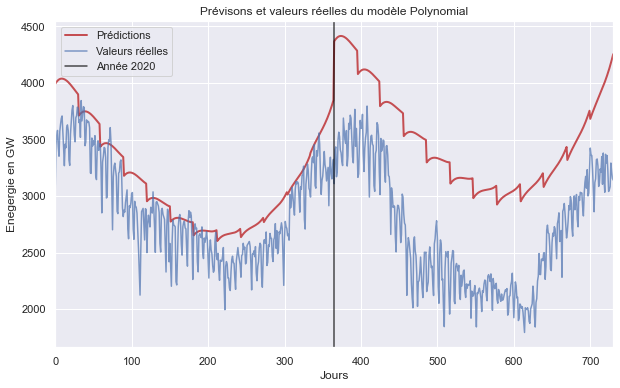

In [12]:
plt.figure(figsize=(10, 6))

plt.plot(test_pred, label='Prédictions', color='r', lw=2)
plt.plot(y.values, label='Valeurs réelles', alpha=.7, color='b')

plt.axvline(x=365, color='black', alpha=.7, label='Année 2020'); # Ajout de la ligne verticale

plt.xlabel('Jours')
plt.ylabel('Enegergie en GW')

plt.xlim([0, 730])

plt.title('Prévisons et valeurs réelles du modèle Polynomial')

plt.legend()

plt.savefig("Outputs/02_-_Distrib_pred_poly.png", dpi=150, bbox_inches='tight')

plt.show()

# IV - Régression Polynomiale Consommation

Nous allons tester ici une régression polynomiale  de degré *3* avec pour `features` *annee*, *mois*, *jour* sur la `target` *consommation*.

## IV.1 - Interprétation des résultats

Le score R2 sur le jeu d'entrainement est autour de .75, ce qui est relativement satisfaisant. Le RMSE est aussi bon ce qui laisse envisager une prédiction assez bonne.

Cependant, lorsque nous regardons la courbe des prévisions et des données réelles, les prédictions sont sous estimées, ce qui est plutôt étonnant puisque la tendance, bien qu'à la baisse, ne l'est pas autant.

## IV.2 - Conclusions

Le modèle n'est finalement pas suffisament satisfaisant.

In [13]:
# On garde seulement ces colonnes
df = pd.read_feather('data/energy_clean.ftr')
df = df.set_index('date_heure')

cols_to_keep = ['annee', 'mois', 'jour', 'consommation']
df = df[cols_to_keep]
# On convertit en GW
df['consommation'] = df['consommation'].apply(lambda x: round(x/1000, 5))
# On fait la somme quotidienne de production
data = df.groupby(['annee','mois', 'jour'])[['consommation']].sum().reset_index()
# On garde en test 2019 et 2020
data_test = data[data['annee'] >= 2019]
# On entraine sur 2013 à 2018
data = data[data['annee'] < 2019]

target = data['consommation']
features = data.drop(columns='consommation')

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.25)

poly = PolynomialFeatures(3) # Degré 3
scaler = StandardScaler() # On utilise un StandardScaler
lr = LinearRegression() # Modèle linéaire

# Création du Pipeline
pipeline=make_pipeline(poly, scaler, lr)
# Entrainement du Pipeline
pipeline.fit(X_train,y_train)
# Prédictions des données de test
y_pred = pipeline.predict(X_test)

# Affichages des métriques
print('Pipeline Score test: ', pipeline.score(X_test, y_test))
print('RMSE test:', round(np.sqrt(mean_squared_error(y_test, y_pred)), 4))

# Prédictions sur les données de Tests
X = data_test.drop(columns=['consommation'])
y = data_test['consommation']

test_pred = pipeline.predict(X)
print('RMSE Preds:', round(np.sqrt(mean_squared_error(y, test_pred)), 4))

Pipeline Score test:  0.704430744084839
RMSE test: 271.7937
RMSE Preds: 473.065


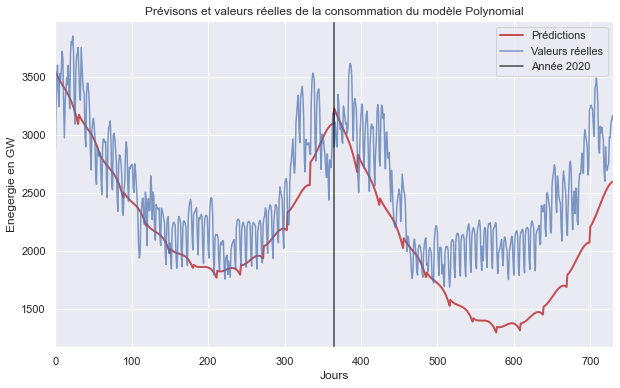

In [14]:
plt.figure(figsize=(10, 6))

plt.plot(test_pred, label='Prédictions', color='r', lw=2)
plt.plot(y.values, label='Valeurs réelles', alpha=.7, color='b')

plt.axvline(x=365, color='black', alpha=.7, label='Année 2020'); # Ajout de la ligne verticale

plt.xlabel('Jours')
plt.ylabel('Enegergie en GW')

plt.xlim([0, 730])

plt.title('Prévisons et valeurs réelles de la consommation du modèle Polynomial')

plt.legend()

plt.savefig("Outputs/02_-_Distrib_pred_poly_conso.png", dpi=150, bbox_inches='tight')

plt.show()